In [1]:
# !pip install nni
# !pip install torch  torchvision==0.16.0 torchaudio==2.1.0
# also need to install graphviz and torchviz

In [2]:
# import pytorch libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
from torch.optim import SGD
from nni.compression.pruning import L1NormPruner
import matplotlib.pyplot as plt
import time
import numpy as np
import copy # use to clone the original model
from matplotlib.ticker import MaxNLocator  # Import the MaxNLocator. ensure x axix is integer
import pandas as pd

print(torch.__version__)

2.1.0


## 1. Pretrain a model using MNIST dataset

In [3]:
# Optional to run code on GPU
# Check if CUDA is available and if device is GPU
print('Cuda Available : {}'.format(torch.cuda.is_available()))
if torch.cuda.is_available():
    print('GPU - {0}'.format(torch.cuda.get_device_name()))

Cuda Available : False


### 1.1 Visualise the dataset MNIST

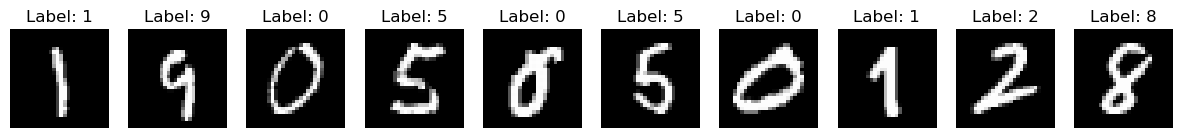

In [4]:
# visualise the dataset
import matplotlib.pyplot as plt
visualise_train = datasets.MNIST('data', train=True, download=True)

# set seed to keep a specific random pattern
np.random.seed(227)
torch.manual_seed(227)

# Define a function to visualize images and their labels
def visualize_samples(dataset, num_samples=10):
    fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
    for i in range(num_samples):
        idx = np.random.randint(len(dataset))  # Random index selection
        image, label = dataset[idx]

        axes[i].imshow(image, cmap='gray')
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')

    plt.show()

# Visualize samples from the training set
visualize_samples(visualise_train)


# Another way while using "transform=transforms.ToTensor()"
# import matplotlib.pyplot as plt
# train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)

# def visualize_samples(dataset, num_samples=10):
#     fig, axes = plt.subplots(1, num_samples, figsize=(15, 3))
#     for i in range(num_samples):
#         idx = np.random.randint(len(dataset))  # Random index selection
#         image, label = dataset[idx]
        
#         # Check if the image has three dimensions and reduce to two if one is a singleton
#         if image.dim() == 3 and image.shape[0] == 1:
#             image = image.squeeze(0)  # Remove the channel dimension for grayscale

#         axes[i].imshow(image.numpy(), cmap='gray')  # Make sure to use `.numpy()` to convert from tensor
#         axes[i].set_title(f'Label: {label}')
#         axes[i].axis('off')

#     plt.show()

# # Example usage with your train_dataset
# visualize_samples(train_dataset)

### 1.2 Define the CNN model


In [5]:
# Define the CNN model

from torch.utils.data import DataLoader, random_split
from torchvision import datasets, transforms

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyperparameters
num_epochs = 20
batch_size = 64
learning_rate = 0.01
sparsity=0.9

# Define transformations
transform = transforms.Compose([
    transforms.ToTensor(),  # Convert PIL Image to tensor
    transforms.Normalize((0.1307,), (0.3081,))  # Normalize the pixel values
])


# # MNIST dataset
# train_dataset = datasets.MNIST(root='data', train=True, transform=transforms.ToTensor(), download=True)
# test_dataset = datasets.MNIST(root='data', train=False, transform=transforms.ToTensor(), download=True)

# Load MNIST dataset with transformations
train_dataset = datasets.MNIST(root='data', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='data', train=False, transform=transform, download=True)


# Split dataset into training and validation sets
train_size = int(0.8 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = random_split(train_dataset, [train_size, val_size])


# # Data loader
# train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
# test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)

# Define data loaders
train_loader = DataLoader(dataset=train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(dataset=val_dataset, batch_size=batch_size, shuffle=False)
test_loader = DataLoader(dataset=test_dataset, batch_size=batch_size, shuffle=False)


# Define a convolutional neural network model for MNIST
class TorchModel(nn.Module):
    def __init__(self, v1=16, v2=4, v3=4):
        super(TorchModel, self).__init__()
        self.v1 = v1  # Typically the number of output channels from the last conv layer
        self.v2 = v2  # Height of the feature map
        self.v3 = v3  # Width of the feature map
        self.conv1 = nn.Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
        self.conv2 = nn.Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
        self.fc1 = nn.Linear(self.v1 * self.v2 * self.v3, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.relu1 = nn.ReLU()
        self.relu2 = nn.ReLU()
        self.relu3 = nn.ReLU()
        self.relu4 = nn.ReLU()
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)

    def forward(self, x):
        x = self.relu1(self.conv1(x))
        x = self.pool1(x)
        x = self.relu2(self.conv2(x))
        x = self.pool2(x)
        # Dynamically calculate the correct number of features for flattening
        x = x.view(x.size(0), -1)  # Automatically calculate the correct number of features
        x = self.relu3(self.fc1(x))
        x = self.relu4(self.fc2(x))
        x = self.fc3(x)
        x = F.log_softmax(x, dim=1)
        return x


model = TorchModel(16, 4, 4).to(device)  # Original model dimensions
print(model)

TorchModel(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=256, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [6]:
# torchviz

# Run the model forward pass and visualize using torchviz:
from torchviz import make_dot

model.eval()  # Set the model to evaluation mode
dummy_input = torch.randn(3, 1, 28, 28)

# Run a forward pass with the dummy input to get the output tensor
output = model(dummy_input)

# Generate the graph using torchviz
dot = make_dot(output, params=dict(model.named_parameters()))

# To display in Jupyter Notebook/JupyterLab
# dot.view()
# Saves the visualization as a PNG file
dot.render('model_original_visualization', format='png')  # Saves the visualization as a PNG file


'model_original_visualization.png'

In [7]:
# sava the model before compression
torch.save(model.state_dict(), 'original_model.pth')

In [8]:

# Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = SGD(model.parameters(), lr=learning_rate)

# Function to train the model, return the average_loss
def train(model, train_loader, optimizer, criterion):
    model.train()
    total_loss = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = criterion(output, target)
        loss.backward()
        optimizer.step()
        total_loss += loss.item() * data.size(0)
    average_loss = total_loss / len(train_loader.dataset)
    return average_loss


# Function to evaluate the model, return the average_loss and accuracy
def evaluate(model, test_loader, criterion):
    model.eval()
    total = 0
    correct = 0
    total_loss = 0.0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            outputs = model(data)
            loss = criterion(outputs, target)
            total_loss += loss.item() * data.size(0)
            _, predicted = torch.max(outputs.data, 1)
            total += target.size(0)
            correct += (predicted == target).sum().item()

    average_loss = total_loss / total
    accuracy = 100 * correct / total
    return average_loss, accuracy


### 1.3 Original model Evaluation

In [9]:
# make a copy of the original model
model_copy = copy.deepcopy(model)
# Reinitialize the optimizer for the copied model
optimizer_copy = SGD(model_copy.parameters(), lr=learning_rate)


In [10]:
# # make a copy of the original model
# model_copy = copy.deepcopy(model)



# # Train original model
# for epoch in range(num_epochs):
#     train(model, train_loader, optimizer, criterion)
#     evaluate(model, val_loader, criterion) #use the validation dataset

# Train original model, collect these metrics for plotting
training_losses = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model_copy, train_loader, optimizer_copy, criterion)
    val_loss, val_accuracy = evaluate(model_copy, val_loader, criterion)
    
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


Epoch 0: Train Loss: 1.1828, Validation Loss: 0.3490, Validation Accuracy: 89.33%
Epoch 1: Train Loss: 0.2549, Validation Loss: 0.1895, Validation Accuracy: 94.31%
Epoch 2: Train Loss: 0.1649, Validation Loss: 0.1470, Validation Accuracy: 95.42%
Epoch 3: Train Loss: 0.1264, Validation Loss: 0.1162, Validation Accuracy: 96.62%
Epoch 4: Train Loss: 0.1046, Validation Loss: 0.1307, Validation Accuracy: 95.66%
Epoch 5: Train Loss: 0.0903, Validation Loss: 0.0825, Validation Accuracy: 97.42%
Epoch 6: Train Loss: 0.0788, Validation Loss: 0.0818, Validation Accuracy: 97.43%
Epoch 7: Train Loss: 0.0714, Validation Loss: 0.0710, Validation Accuracy: 97.84%
Epoch 8: Train Loss: 0.0654, Validation Loss: 0.0629, Validation Accuracy: 98.12%
Epoch 9: Train Loss: 0.0592, Validation Loss: 0.0729, Validation Accuracy: 97.71%
Epoch 10: Train Loss: 0.0547, Validation Loss: 0.0596, Validation Accuracy: 98.16%
Epoch 11: Train Loss: 0.0513, Validation Loss: 0.0563, Validation Accuracy: 98.22%
Epoch 12: Trai

In [11]:
# Start timing
start_time = time.time()

# Test original model
original_test_accuracy = evaluate(model_copy, test_loader, criterion)

# End timing
end_time = time.time()
total_time_original = end_time - start_time

print(f"Original Model Test Accuracy: {original_test_accuracy}")

Original Model Test Accuracy: (0.04569546606000513, 98.58)


In [12]:
# # try not to train the original model, to keep the validation of the original model and pruned model on the same page(all have 10 epoch in total)

# # Start timing
# import time
# start_time = time.time()


# # # Train original model
# # for epoch in range(num_epochs):
# #     train(model, train_loader, optimizer, criterion)
# #     evaluate(model, val_loader, criterion) #use the validation dataset

# # Train original model, collect these metrics for plotting
# training_losses = []
# validation_losses = []
# validation_accuracies = []

# for epoch in range(num_epochs):
#     train_loss = train(model, train_loader, optimizer, criterion)
#     val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
#     training_losses.append(train_loss)
#     validation_losses.append(val_loss)
#     validation_accuracies.append(val_accuracy)
    
#     print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")


# # End timing
# end_time = time.time()
# total_time_original = end_time - start_time

# # Test original model
# original_test_accuracy = evaluate(model, test_loader, criterion)
# print(f"Original Model Test Accuracy: {original_test_accuracy}")

### 1.4 Plotting the Original model's loss and accuracy

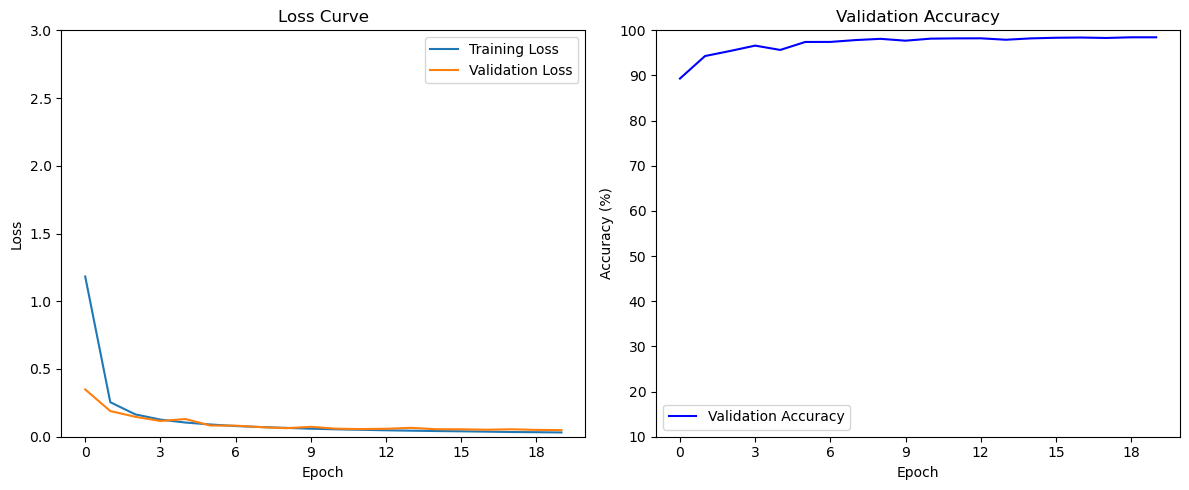

In [13]:

# Plotting the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3)  # Setting the y-axis range from 0 to 3 for loss
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer labels


# Plotting the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(10, 100)  # Setting the y-axis range from 10 to 100 for accuracy
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer labels

plt.tight_layout()
plt.show()


## 2. Pruning process start

In [14]:
# Pruning configuration
config_list = [{
    'op_types': ['Linear', 'Conv2d'],
    'exclude_op_names': ['fc3'],
    'sparse_ratio': sparsity
}]

# Apply L1NormPruner
pruner = L1NormPruner(model, config_list)
# model = pruner.compress()[0]
# print(pruner)
# print(model)



### 2.1 Generate the masks

In [15]:
# compress the model and generate the masks
_, masks = pruner.compress()
# show the masks sparsity
for name, mask in masks.items():
    print(name, ' sparsity : ', '{:.2}'.format(mask['weight'].sum() / mask['weight'].numel()))

conv1  sparsity :  0.17
fc2  sparsity :  0.11
fc1  sparsity :  0.1
conv2  sparsity :  0.12


In [16]:
# need to unwrap the model, if the model is wrapped before speedup
pruner.unwrap_model()

# speedup the model, for more information about speedup, please refer :doc:`pruning_speedup`.
from nni.compression.speedup import ModelSpeedup

m_speedup = ModelSpeedup(model, torch.rand(3, 1, 28, 28).to(device), masks)
m_speedup.speedup_model()


# ModelSpeedup(model, torch.rand(3, 1, 28, 28).to(device), masks).speedup_model()
# (3, 1, 28, 28) in the code represents the dimensions of a tensor

# 3: The number of data samples in the batch. This means that the input consists of 3 separate images being processed simultaneously.
# 1: The number of channels in each image. For grayscale images, such as those typically used in the MNIST dataset, this number is 1. If it were a color image in a standard RGB format, this number would be 3.
# 28, 28: The dimensions of each image. In the case of the MNIST dataset, each image is 28 pixels wide by 28 pixels high.


[2024-05-08 18:53:27] Start to speedup the model...
[2024-05-08 18:53:27] Resolve the mask conflict before mask propagate...
[2024-05-08 18:53:27] dim0 sparsity: 0.863636
[2024-05-08 18:53:27] dim1 sparsity: 0.000000
0 Filter
[2024-05-08 18:53:27] dim0 sparsity: 0.863636
[2024-05-08 18:53:27] dim1 sparsity: 0.000000
[2024-05-08 18:53:27] Infer module masks...
[2024-05-08 18:53:27] Propagate original variables
[2024-05-08 18:53:27] Propagate variables for placeholder: x, output mask:  0.0000 
[2024-05-08 18:53:27] Propagate variables for call_module: conv1, weight:  0.8333 bias:  0.8333 , output mask:  0.0000 
[2024-05-08 18:53:27] Propagate variables for call_module: relu1, , output mask:  0.0000 
[2024-05-08 18:53:27] Propagate variables for call_module: pool1, , output mask:  0.0000 
[2024-05-08 18:53:27] Propagate variables for call_module: conv2, weight:  0.8750 bias:  0.8750 , output mask:  0.0000 
[2024-05-08 18:53:27] Propagate variables for call_module: relu2, , output mask:  0

TorchModel(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)

In [17]:
print(model)
# 这里是pruned model， 经过prunning：
# layer的数量和layer的类型都没有变化
# 但是由于prune掉了一些weights，所以layer的output weights的个数有减少，也是因此，TorchModel()变了，因此最后要测量eval就需要重新定义TorchModel()

TorchModel(
  (conv1): Conv2d(1, 1, kernel_size=(5, 5), stride=(1, 1))
  (conv2): Conv2d(1, 2, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=32, out_features=12, bias=True)
  (fc2): Linear(in_features=12, out_features=9, bias=True)
  (fc3): Linear(in_features=9, out_features=10, bias=True)
  (relu1): ReLU()
  (relu2): ReLU()
  (relu3): ReLU()
  (relu4): ReLU()
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
)


In [18]:
model.eval()  # Set the model to evaluation mode
dummy_input = torch.randn(3, 1, 28, 28)

# Run a forward pass with the dummy input to get the output tensor
output = model(dummy_input)

# Generate the graph using torchviz
dot = make_dot(output, params=dict(model.named_parameters()))

# To display in Jupyter Notebook/JupyterLab
# dot.view()
# Saves the visualization as a PNG file
dot.render('model_pruned_visualization', format='png')  # Saves the visualization as a PNG file


'model_pruned_visualization.png'

### 2.2 Fine-tuning Compacted Model
Note that if the model has been sped up, you need to re-initialize a new optimizer for fine-tuning.
Because speedup will replace the masked big layers with dense small ones.
>After pruning and speedup, the model is typically smaller and faster, but it may also lose some accuracy or require adjustment to fully adapt to its new structure, which is where fine-tuning comes in.



In [19]:
# Fine-tuning loop for the pruned model

optimizer = SGD(model.parameters(), 1e-2) # 0.01 is the learning rate
criterion = F.nll_loss


# for epoch in range(num_epochs):
#     train(model, train_loader, optimizer, criterion)
#     evaluate(model, val_loader, criterion) # Validate during fine-tuning

training_losses = []
validation_losses = []
validation_accuracies = []

for epoch in range(num_epochs):
    train_loss = train(model, train_loader, optimizer, criterion)
    val_loss, val_accuracy = evaluate(model, val_loader, criterion)
    
    training_losses.append(train_loss)
    validation_losses.append(val_loss)
    validation_accuracies.append(val_accuracy)
    
    print(f"Epoch {epoch}: Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%")

# Start timing
start_time = time.time()

# Test pruned model
pruned_test_accuracy = evaluate(model, test_loader, criterion)

# End timing
end_time = time.time()
total_time_compressed = end_time - start_time
print(f"Pruned Model Test Accuracy: {pruned_test_accuracy}")

Epoch 0: Train Loss: 2.3022, Validation Loss: 2.3013, Validation Accuracy: 11.60%
Epoch 1: Train Loss: 2.3015, Validation Loss: 2.3009, Validation Accuracy: 11.60%
Epoch 2: Train Loss: 2.3013, Validation Loss: 2.3007, Validation Accuracy: 11.60%
Epoch 3: Train Loss: 2.3012, Validation Loss: 2.3006, Validation Accuracy: 11.60%
Epoch 4: Train Loss: 2.3011, Validation Loss: 2.3005, Validation Accuracy: 11.60%
Epoch 5: Train Loss: 2.3010, Validation Loss: 2.3002, Validation Accuracy: 11.60%
Epoch 6: Train Loss: 2.3006, Validation Loss: 2.2996, Validation Accuracy: 11.60%
Epoch 7: Train Loss: 2.2993, Validation Loss: 2.2970, Validation Accuracy: 11.60%
Epoch 8: Train Loss: 2.2734, Validation Loss: 2.1132, Validation Accuracy: 19.08%
Epoch 9: Train Loss: 1.4361, Validation Loss: 1.0997, Validation Accuracy: 64.38%
Epoch 10: Train Loss: 0.9542, Validation Loss: 0.8631, Validation Accuracy: 72.88%
Epoch 11: Train Loss: 0.7254, Validation Loss: 0.6230, Validation Accuracy: 79.99%
Epoch 12: Trai

### 2.3 Get the runtime of the pruned model

In [20]:
# Start timing
start_time = time.time()

# Test pruned model
pruned_test_accuracy = evaluate(model, test_loader, criterion)

# End timing
end_time = time.time()
total_time_compressed = end_time - start_time

print(f"Pruned Model Test Accuracy: {pruned_test_accuracy}")

Pruned Model Test Accuracy: (0.27467546964883804, 91.55)


In [21]:
# export the evaluation data to csv

import pandas as pd

# Create a DataFrame from your lists
data = {
    'Training Losses': training_losses,
    'Validation Losses': validation_losses,
    'Validation Accuracies': validation_accuracies
}

df = pd.DataFrame(data)

# Save the DataFrame to a CSV file
csv_file_name = 'pruned_sparsity_runtime_test_only000.csv'
df.to_csv(csv_file_name, index=False)
print(f"Data saved to {csv_file_name}")

Data saved to pruned_sparsity_runtime_test_only000.csv


### 2.4 Plotting the Pruned model's loss and accuracy

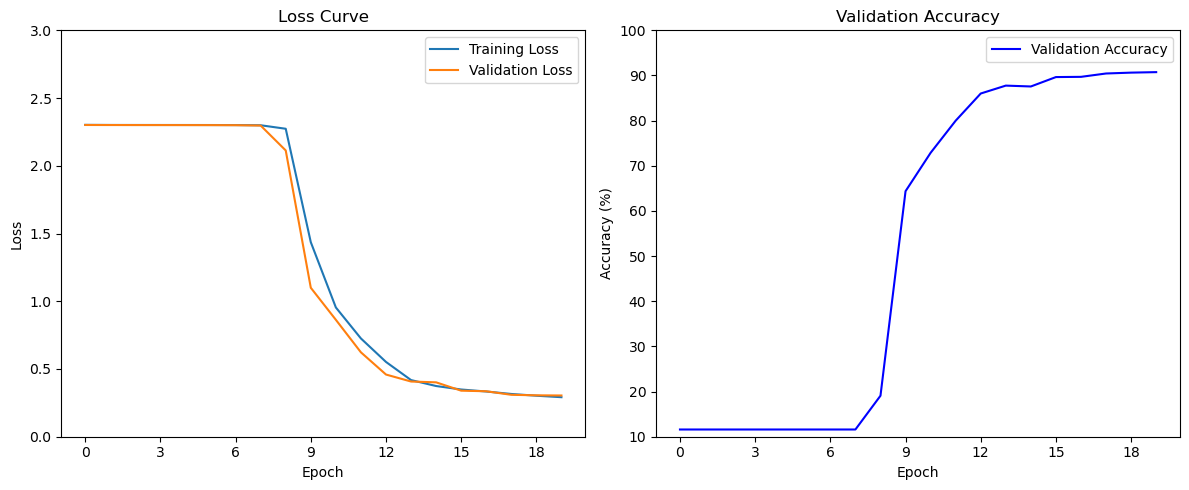

In [22]:
# Plotting the loss curves
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(training_losses, label='Training Loss')
plt.plot(validation_losses, label='Validation Loss')
plt.title('Loss Curve')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.ylim(0, 3)  # Setting the y-axis range from 0 to 3 for loss
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer labels


# Plotting the accuracy curve
plt.subplot(1, 2, 2)
plt.plot(validation_accuracies, label='Validation Accuracy', color='blue')
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(10, 100)  # Setting the y-axis range from 10 to 100 for accuracy
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer labels


plt.tight_layout()
plt.show()


In [23]:
# sava the model after compression
torch.save(model.state_dict(), 'compressed_model.pth')

##  3. Validation of Model compression


1. the model size
2. execution time


1. the model size

In [24]:
import os

size_original = os.path.getsize('original_model.pth')
size_compressed = os.path.getsize('compressed_model.pth')
print(f'Original Model Size: {size_original} bytes')
print(f'Compressed Model Size: {size_compressed} bytes')
print(f'Reduction in Size: {size_original - size_compressed} bytes')


Original Model Size: 181466 bytes
Compressed Model Size: 6454 bytes
Reduction in Size: 175012 bytes


2.the execution time

In [25]:
training_time_reduction=total_time_original-total_time_compressed
print(f'Original Model Runtime: {total_time_original}')
print(f'Compressed Model Runtime: {total_time_compressed}')
print(f'Reduction in Runtime: {training_time_reduction}')

Original Model Runtime: 0.667543888092041
Compressed Model Runtime: 0.4761679172515869
Reduction in Runtime: 0.1913759708404541


# load multiple pruned data in different parsity values

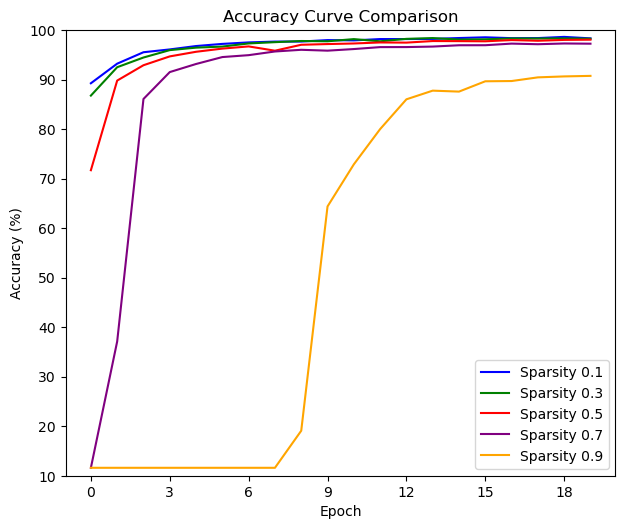

In [26]:
# Load the data from the CSV file
df_01 = pd.read_csv('pruned_sparsity_0-1-report.csv')
df_03 = pd.read_csv('pruned_sparsity_0-3-report.csv')
df_05 = pd.read_csv('pruned_sparsity_0-5-report.csv')
df_07 = pd.read_csv('pruned_sparsity_0-7-report.csv')
df_09 = pd.read_csv('pruned_sparsity_0-9-report.csv')


# # Print to verify it loaded correctly
# print(df_05.head())


# Plotting the loss curves
# plt.figure(figsize=(12, 5))
plt.figure(figsize=(12, 10))


# plt.subplot(1, 2, 1)
# plt.plot(training_losses, label='Training Loss')
# plt.plot(validation_losses, label='Validation Loss')
# plt.title('Loss Curve')
# plt.xlabel('Epoch')
# plt.ylabel('Loss')
# plt.ylim(0, 3)  # Setting the y-axis range from 0 to 3 for loss
# plt.legend()
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer labels


# # Plotting the accuracy curve
# plt.subplot(1, 2, 2)
# plt.plot(validation_accuracies, label='Validation Accuracy', color='blue')
# plt.title('Validation Accuracy')
# plt.xlabel('Epoch')
# plt.ylabel('Accuracy (%)')
# plt.ylim(10, 100)  # Setting the y-axis range from 10 to 100 for accuracy
# plt.legend()
# plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))  # Ensure x-axis has integer labels


# Plotting the accuracy curves
plt.subplot(2, 2, 1) # 2行1列，第1个
plt.plot(df_01['Validation Accuracies'], label='Sparsity 0.1', color='blue')
plt.plot(df_03['Validation Accuracies'], label='Sparsity 0.3', color='green')
plt.plot(df_05['Validation Accuracies'], label='Sparsity 0.5', color='red')
plt.plot(df_07['Validation Accuracies'], label='Sparsity 0.7', color='purple')
plt.plot(df_09['Validation Accuracies'], label='Sparsity 0.9', color='orange')
plt.title('Accuracy Curve Comparison')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.ylim(10, 100)
plt.legend()
plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True))


plt.tight_layout()
plt.show()



## plot the Model Size Analysis in stacked column graph 

In [28]:
# Load the CSV data into a DataFrame
df = pd.read_csv('compression_ratio_sparsity.csv')
# print(df)
# print(df.columns)


In [29]:
# Calculate the total original size by adding both columns
df['Total Original Size'] = df['Compressed Model Size'] + df['Reduction in Size']

# Calculate proportions for plotting
df['Compressed Proportion'] = df['Compressed Model Size'] / df['Total Original Size']
df['Reduction Proportion'] = df['Reduction in Size'] / df['Total Original Size']


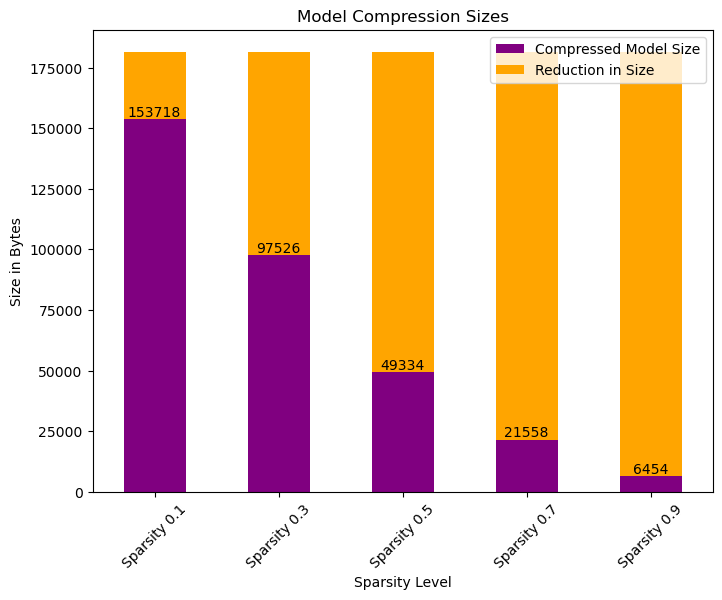

In [30]:
import matplotlib.pyplot as plt

# Manually create sparsity labels if they are known and sequential
sparsity_levels = [0.1, 0.3, 0.5, 0.7, 0.9]
df['Sparsity'] = ['Sparsity ' + str(level) for level in sparsity_levels]

# Set this new column as the index
df.set_index('Sparsity', inplace=True)


# Plotting
# fig, ax = plt.subplots(figsize=(10, 6))
fig, ax = plt.subplots(figsize=(8, 6))

# Creating the bar plot
bars = df[['Compressed Model Size', 'Reduction in Size']].plot(kind='bar', stacked=True, color=['purple', 'orange'], ax=ax)
ax.set_ylabel('Size in Bytes')
ax.set_xlabel('Sparsity Level')
ax.set_title('Model Compression Sizes')
plt.xticks(rotation=45)
plt.legend(['Compressed Model Size', 'Reduction in Size'], loc='upper right')

# Iterate over each bar to label only the "Compressed Model Size"
for idx, bar in enumerate(bars.patches[:len(df)]):  # Limit to the first set of bars which are 'Compressed Model Size'
    label_x = bar.get_x() + bar.get_width() / 2
    label_y = bar.get_height()
    label_text = f'{int(label_y)}'
    ax.text(label_x, label_y, label_text, ha='center', va='bottom', color='black', fontsize=10)

plt.show()

## plot the Runtime Analysis 

In [74]:
# Load the CSV data into a DataFrame
df = pd.read_csv('compression_runtime_sparsity.csv')

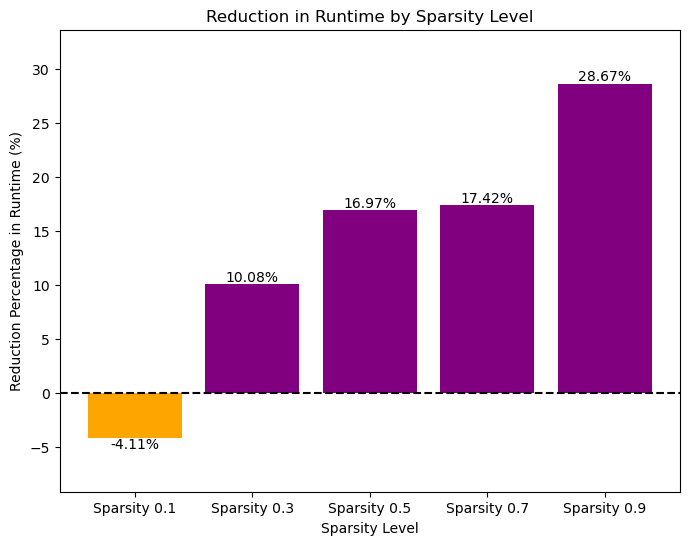

In [80]:
# Assuming 'df' is your DataFrame and it's already loaded correctly
df = pd.DataFrame({
    'Sparsity': ['Sparsity 0.1', 'Sparsity 0.3', 'Sparsity 0.5', 'Sparsity 0.7', 'Sparsity 0.9'],
    'Speedup ratio in Runtime': [-4.11, 10.08, 16.97, 17.42, 28.67]
})

plt.figure(figsize=(8, 6))
bars = plt.bar(df['Sparsity'], df['Speedup ratio in Runtime'], color=['purple' if x >= 0 else 'orange' for x in df['Speedup ratio in Runtime']])

plt.xlabel('Sparsity Level')
plt.ylabel('Reduction Percentage in Runtime (%)')
plt.title('Reduction in Runtime by Sparsity Level')

# Adding a horizontal line at zero for reference
plt.axhline(0, color='black', linestyle='--', linewidth=1.5)

# Setting y-axis limits to accommodate all values and additional space for text labels
plt.ylim(min(df['Speedup ratio in Runtime']) - 5, max(df['Speedup ratio in Runtime']) + 5)

# Adding labels to bars for clarity
for bar in bars:
    y_val = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, y_val, f'{y_val:.2f}%', ha='center', va='bottom' if y_val > 0 else 'top')

# Enhancing grid visibility for ease of reading
plt.grid(False)
# plt.grid(True, which='both', linestyle='--', linewidth=0.5)

plt.show()